In [ ]:
# Задача
# 1. Сгенерируйте набор данных для предсказания временных последовательностей. Выполните тренировку RNN
# 2. Модифицируйте сеть, используя в качестве рекуррентного слоя LSTM слой библиотеки pytorch.
# https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

# 3. решите задачу набора данных лекции 7.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

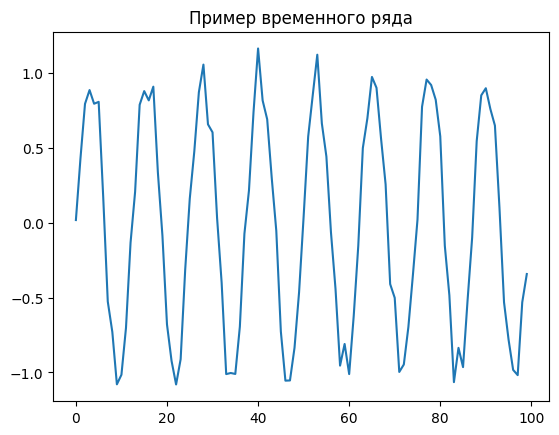

In [2]:
# Генерация синтетических данных
def generate_sine_wave(seq_length=100, num_sequences=1000):
    x = np.linspace(0, 50, seq_length)
    y = np.sin(x) + np.random.normal(0, 0.1, size=(num_sequences, seq_length))  # Добавляем шум
    return y

# Генерируем 1000 последовательностей длиной 100
data = generate_sine_wave(seq_length=100, num_sequences=1000)

# Преобразуем данные в тензор PyTorch
data_tensor = torch.tensor(data, dtype=torch.float32)

# Показать пример данных
plt.plot(data[0])
plt.title("Пример временного ряда")
plt.show()

In [3]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Используем последний выход RNN
        return out

In [4]:
# Подготовка данных для обучения
# Делаем данные в формате (batch_size, sequence_length, input_size)
input_data = data_tensor[:, :-1].unsqueeze(-1)  # Все данные, кроме последнего элемента
target_data = data_tensor[:, -1].unsqueeze(-1)  # Только последний элемент в качестве цели

# Разделим на обучающую и тестовую выборки
train_size = int(0.8 * len(data))
train_data, test_data = input_data[:train_size], input_data[train_size:]
train_target, test_target = target_data[:train_size], target_data[train_size:]

In [5]:
# Модель, критерий и оптимизатор
model_rnn = RNNModel(input_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)

# Обучение модели RNN
epochs = 100
for epoch in range(epochs):
    model_rnn.train()
    optimizer.zero_grad()

    output = model_rnn(train_data)
    loss = criterion(output, train_target)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

Epoch 0/100, Loss: 0.06094464287161827
Epoch 10/100, Loss: 0.015301642008125782
Epoch 20/100, Loss: 0.011579020880162716
Epoch 30/100, Loss: 0.010179337114095688
Epoch 40/100, Loss: 0.01015231292694807
Epoch 50/100, Loss: 0.010168688371777534
Epoch 60/100, Loss: 0.01012490876019001
Epoch 70/100, Loss: 0.01009439304471016
Epoch 80/100, Loss: 0.01007844414561987
Epoch 90/100, Loss: 0.010067485272884369


In [6]:
# Оценка модели
model_rnn.eval()
with torch.no_grad():
    predictions = model_rnn(test_data)
    test_loss = criterion(predictions, test_target)
    print(f"Test Loss: {test_loss.item()}")

Test Loss: 0.010261375457048416


In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Используем последний выход LSTM
        return out

In [8]:
# Модель, критерий и оптимизатор для LSTM
model_lstm = LSTMModel(input_size=1)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

# Обучение модели LSTM
for epoch in range(epochs):
    model_lstm.train()
    optimizer.zero_grad()

    output = model_lstm(train_data)
    loss = criterion(output, train_target)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")


Epoch 0/100, Loss: 0.02268024906516075
Epoch 10/100, Loss: 0.011055364273488522
Epoch 20/100, Loss: 0.01001613400876522
Epoch 30/100, Loss: 0.010195582173764706
Epoch 40/100, Loss: 0.010059577412903309
Epoch 50/100, Loss: 0.010016224347054958
Epoch 60/100, Loss: 0.010023203678429127
Epoch 70/100, Loss: 0.010019099339842796
Epoch 80/100, Loss: 0.010016032494604588
Epoch 90/100, Loss: 0.010015537962317467


In [9]:
# Оценка модели
model_lstm.eval()
with torch.no_grad():
    predictions = model_lstm(test_data)
    test_loss = criterion(predictions, test_target)
    print(f"Test Loss (LSTM): {test_loss.item()}")

Test Loss (LSTM): 0.010295424610376358


In [10]:
import matplotlib.pyplot as plt

# Обучение модели RNN
model_rnn.eval()
with torch.no_grad():
    rnn_predictions = model_rnn(test_data)

# Обучение модели LSTM
model_lstm.eval()
with torch.no_grad():
    lstm_predictions = model_lstm(test_data)

# Преобразуем предсказания и реальные значения в Python списки для удобства визуализации
rnn_predictions = rnn_predictions.squeeze().tolist()
lstm_predictions = lstm_predictions.squeeze().tolist()
test_target = test_target.squeeze().tolist()


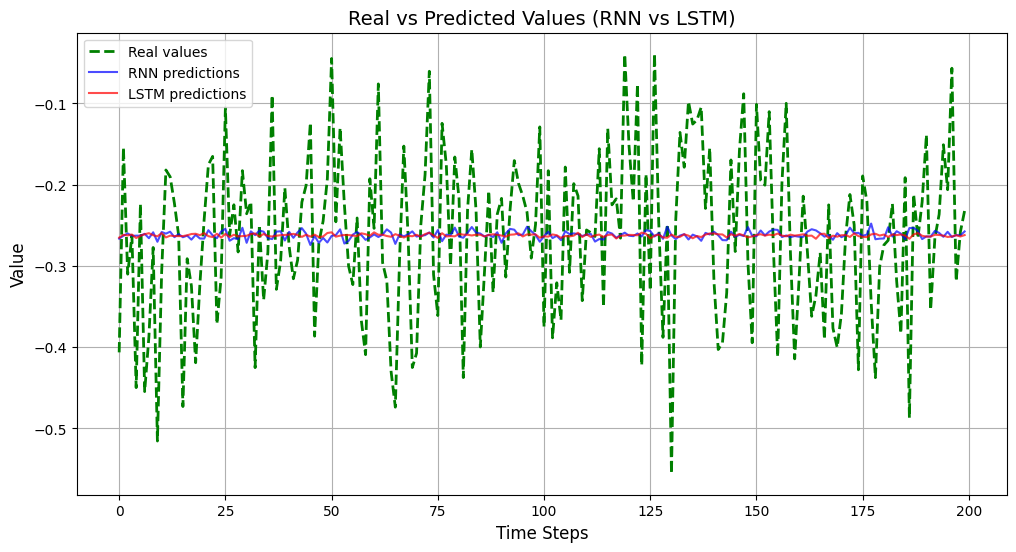

In [12]:
# Визуализация результатов
plt.figure(figsize=(12, 6))

# Истинные значения
plt.plot(test_target, label='Real values', color='green', linestyle='--', linewidth=2)

# Результаты модели RNN
plt.plot(rnn_predictions, label='RNN predictions', color='blue', linestyle='-', alpha=0.7)

# Результаты модели LSTM
plt.plot(lstm_predictions, label='LSTM predictions', color='red', linestyle='-', alpha=0.7)

plt.title('Real vs Predicted Values (RNN vs LSTM)', fontsize=14)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

#Из лекции 7
# Задание (файл 2)
# Разделить данные на N групп. (возможно, выбрать первые M данных для обучения)
# Реализовать предсказание ARIMA для 2 (тренировочной группы) на основе 1. Рассчитать MSE.
# Исследовать качество работы модели в зависимости от параметров (для групп 1-2).
# (1)Выполнить итеративное предсказание, данные для каждого следующего предсказания обновлять по методу
# "экспоненциальное среднее".

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error


--- Модель ARIMA для группы 1 ---
Ошибка MSE для модели ARIMA(1,0,0): 5.7036246443


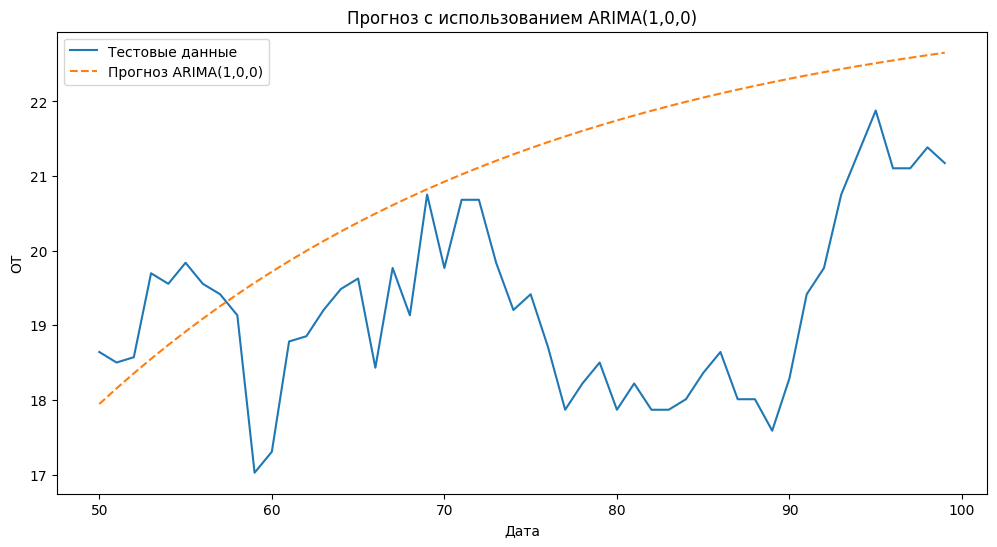

In [14]:
#Загрузка данных
df = pd.read_csv('ETTm1.csv')
x = df.OT  # или любой другой столбец временного ряда

# Разделение на тренировочные и тестовые группы
M = 50  # Количество данных для обучения
N = 50  # Количество данных для теста

x_train = x[:M]  # Первая группа для обучения
x_test = x[M:M+N]  # Вторая группа для теста

# Построение модели ARIMA
print("\n--- Модель ARIMA для группы 1 ---")
# ARIMA(1,0,0) для примера
model_arima = ARIMA(x_train, order=(1, 0, 0)).fit()
predictions_arima = model_arima.forecast(len(x_test))

# Оценка ошибки модели ARIMA (MSE)
mse_arima = mean_squared_error(x_test, predictions_arima)
print(f'Ошибка MSE для модели ARIMA(1,0,0): {mse_arima:.10f}')

plt.figure(figsize=(12, 6))
plt.plot(x_test, label='Тестовые данные')
plt.plot(predictions_arima, label='Прогноз ARIMA(1,0,0)', linestyle='--')
plt.title('Прогноз с использованием ARIMA(1,0,0)')
plt.xlabel('Дата')
plt.ylabel('OT')
plt.legend()
plt.show()


--- Итеративное предсказание с использованием экспоненциального сглаживания ---


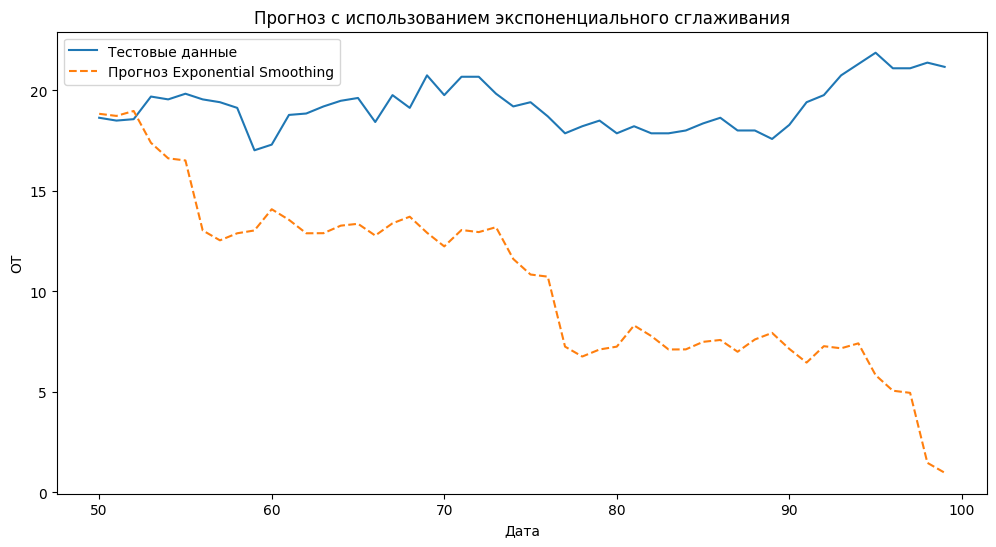

Ошибка MSE для модели Exponential Smoothing: 96.5208004445


In [15]:
# Итеративное предсказание с использованием экспоненциального сглаживания
print("\n--- Итеративное предсказание с использованием экспоненциального сглаживания ---")
# Начальные данные для прогноза
x_train_iter = x[:M]
x_test_iter = x[M:M+N]

# Используем экспоненциальное сглаживание
exp_model = ExponentialSmoothing(x_train_iter, trend='add', seasonal='add', seasonal_periods=21).fit()
exp_predictions = exp_model.forecast(len(x_test_iter))

# Строим график
plt.figure(figsize=(12, 6))
plt.plot(x_test_iter, label='Тестовые данные')
plt.plot(exp_predictions, label='Прогноз Exponential Smoothing', linestyle='--')
plt.title('Прогноз с использованием экспоненциального сглаживания')
plt.xlabel('Дата')
plt.ylabel('OT')
plt.legend()
plt.show()

# Оценка ошибки модели экспоненциального сглаживания (MSE)
mse_exp = mean_squared_error(x_test_iter, exp_predictions)
print(f'Ошибка MSE для модели Exponential Smoothing: {mse_exp:.10f}')